### Setup

In [ ]:
# !pip install torch torchinfo

In [ ]:
import os
import glob
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from PIL import Image
from collections import Counter

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir("/content/drive/MyDrive/")
os.chdir("./spectrogram_data/")
!ls -d */

high_res/


In [ ]:
DATA_DIR = "./high_res"  # Replace with your folder path
BATCH_SIZE = 16 # Small batch size for small data
NUM_CLASSES = 5
IMG_SIZE = 224
CLASSES = ["up", "down", "right", "left", "push"]
CLASS_TO_IDX = {cls_name: idx for idx, cls_name in enumerate(CLASSES)}
print(CLASS_TO_IDX)

{'up': 0, 'down': 1, 'right': 2, 'left': 3, 'push': 4}


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### Pre-processing Dataset

In [ ]:
class SpectrogramDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        img_path = self.file_paths[idx]
        label = self.labels[idx]

        # Load image and convert to RGB (3 channels)
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
def get_data_loaders(data_dir, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1):
    # Validate ratios
    assert train_ratio > 0, "Train split percentage must be greater than 0."
    assert val_ratio > 0, "Validation split percentage must be greater than 0."
    # Using a small epsilon for float comparison
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6, "Train, validation, and test splits must sum to 1.0."

    # Get all .png files
    all_files = glob.glob(os.path.join(data_dir, "*.png"))

    # Parse labels from filenames
    X = []
    y = []

    print(f"Found {len(all_files)} images.")

    for f_path in all_files:
        filename = os.path.basename(f_path)
        parts = filename.split('_')

        found_label = None
        for part in parts:
            if part in CLASS_TO_IDX:
                found_label = CLASS_TO_IDX[part]
                break

        if found_label is not None:
            X.append(f_path)
            y.append(found_label)
        else:
            print(f"Skipping file (no valid class found): {filename}")

    # Initial split: Train and (Validation + Test)
    # If val_ratio + test_ratio is 0, this will effectively make X_rem and y_rem empty.
    if val_ratio + test_ratio > 0:
        X_train, X_rem, y_train, y_rem = train_test_split(
            X, y, test_size=(val_ratio + test_ratio), stratify=y, random_state=42
        )
    else:
        X_train, y_train = X, y
        X_rem, y_rem = [], []

    X_val, y_val = [], []
    X_test, y_test = [], []

    if len(X_rem) > 0:
        if test_ratio == 0:
            # If no test set is needed, the remaining data goes entirely to validation
            X_val, y_val = X_rem, y_rem
            print("Note: Test split is 0%. No separate test loader will be created.")
        else:
            # Split the remaining data into validation and test
            # Calculate the test_size relative to the 'rem' dataset
            # e.g., if val=0.1, test=0.1, then test_size = 0.1 / (0.1 + 0.1) = 0.5
            relative_test_size = test_ratio / (val_ratio + test_ratio)
            X_val, X_test, y_val, y_test = train_test_split(
                X_rem, y_rem, test_size=relative_test_size, stratify=y_rem, random_state=42
            )

    print(f"Split sizes -> Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

    # Define Transforms
    # Strong augmentation for training to prevent overfitting
    train_transforms = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
        # transforms.RandomHorizontalFlip(), # DISABLED for spectrograms usually
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    val_test_transforms = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    # Create Datasets
    train_ds = SpectrogramDataset(X_train, y_train, transform=train_transforms)
    val_ds = SpectrogramDataset(X_val, y_val, transform=val_test_transforms)

    test_ds = None
    if len(X_test) > 0:
        test_ds = SpectrogramDataset(X_test, y_test, transform=val_test_transforms)

    # Create Loaders
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

    test_loader = None
    if test_ds is not None:
        test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

    return train_loader, val_loader, test_loader

In [ ]:
# train_loader, val_loader, test_loader = get_data_loaders(DATA_DIR, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1)

train_loader, val_loader, test_loader = get_data_loaders(DATA_DIR, train_ratio=0.8, val_ratio=0.2, test_ratio=0)

### Build Models

#### Different Models

In [ ]:
def build_convnext_tiny(num_classes, freeze_layers=True):
    # Load Pre-trained ConvNeXt Tiny
    # 'DEFAULT' weights are usually ImageNet-1K
    model = models.convnext_tiny(weights='DEFAULT')

    if freeze_layers:
        # Freeze all parameters in the feature extraction layers
        for param in model.parameters():
            param.requires_grad = False

    last_layer_input = model.classifier[2].in_features
    model.classifier[2] = nn.Linear(last_layer_input, num_classes)

    return model

def build_resnet18(num_classes, freeze_layers=True):
    """
    Builds and modifies a pre-trained ResNet18 model for custom classification.
    """
    # Load ResNet18 pre-trained on ImageNet
    model = models.resnet18(weights='IMAGENET1K_V1')

    if freeze_layers:
        # Freeze all parameters in the feature extraction layers
        for param in model.parameters():
            param.requires_grad = False

    # Get the number of input features to the final fully-connected (fc) layer
    num_ftrs = model.fc.in_features

    # Replace the classification head to match the number of classes
    model.fc = nn.Linear(num_ftrs, num_classes)

    print(f"ResNet18 loaded. Final layer output set to {num_classes} classes.")
    return model

def build_efficientnet_b0(num_classes, freeze_layers=True):
    """
    Builds and modifies a pre-trained EfficientNet-B0 model.
    """
    # Load EfficientNet-B0 pre-trained on ImageNet
    # 'DEFAULT' uses IMAGENET1K_V1
    model = models.efficientnet_b0(weights='DEFAULT')

    if freeze_layers:
        # Freeze all parameters in the feature extraction layers
        for param in model.features.parameters():
            param.requires_grad = False

    # EfficientNet's classifier is a Sequential layer. We replace the last Linear layer (index [1])
    # The input features are taken from the second to last layer
    last_layer_input = model.classifier[1].in_features

    # Create a new classifier with the correct output size
    model.classifier[1] = nn.Linear(last_layer_input, num_classes)

    print(f"EfficientNet-B0 loaded. Final layer output set to {num_classes} classes.")
    return model

def build_mobilenet_v3_large(num_classes, freeze_layers=True):
    """
    Builds MobileNetV3 Large.
    """
    model = models.mobilenet_v3_large(weights='DEFAULT')

    if freeze_layers:
        for param in model.features.parameters():
            param.requires_grad = False

    # MobileNetV3 classifier is a Sequential block. The last layer is the Linear one.
    # model.classifier[-1] is the final Linear layer
    last_layer_input = model.classifier[-1].in_features
    model.classifier[-1] = nn.Linear(last_layer_input, num_classes)

    print(f"MobileNetV3 Large loaded. Final layer output set to {num_classes} classes.")
    return model

def build_densenet121(num_classes, freeze_layers=True):
    """
    Builds DenseNet121.
    """
    model = models.densenet121(weights='DEFAULT')

    if freeze_layers:
        for param in model.features.parameters():
            param.requires_grad = False

    # DenseNet classifier is a single Linear layer named 'classifier'
    last_layer_input = model.classifier.in_features
    model.classifier = nn.Linear(last_layer_input, num_classes)

    print(f"DenseNet121 loaded. Final layer output set to {num_classes} classes.")
    return model

def build_resnet50(num_classes, freeze_layers=True):
    """
    Builds ResNet50.
    """
    model = models.resnet50(weights='DEFAULT')

    if freeze_layers:
        for param in model.parameters():
            param.requires_grad = False

    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)

    print(f"ResNet50 loaded. Final layer output set to {num_classes} classes.")
    return model

def build_vgg16(num_classes, freeze_layers=True):
    """
    Builds VGG16 (with Batch Normalization).
    """
    # Using BN version for better training stability
    model = models.vgg16_bn(weights='DEFAULT')

    if freeze_layers:
        for param in model.features.parameters():
            param.requires_grad = False

    # VGG classifier is a Sequential block.
    # The last layer is at index 6
    last_layer_input = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(last_layer_input, num_classes)

    print(f"VGG16 (BN) loaded. Final layer output set to {num_classes} classes.")
    return model

def build_vgg19(num_classes, freeze_layers=True):
    """
    Builds VGG19 (with Batch Normalization).
    """
    model = models.vgg19_bn(weights='DEFAULT')

    if freeze_layers:
        for param in model.features.parameters():
            param.requires_grad = False

    last_layer_input = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(last_layer_input, num_classes)

    print(f"VGG19 (BN) loaded. Final layer output set to {num_classes} classes.")
    return model

In [ ]:
def get_model(model_name):
    if model_name == 'convnext_tiny':
        return build_convnext_tiny(NUM_CLASSES)

    elif model_name == 'resnet18':
        return build_resnet18(NUM_CLASSES)

    elif model_name == 'efficientnet_b0':
        return build_efficientnet_b0(NUM_CLASSES)

    elif model_name == 'mobilenet_v3_large':
        return build_mobilenet_v3_large(NUM_CLASSES)

    elif model_name == 'densenet121':
        return build_densenet121(NUM_CLASSES)

    elif model_name == 'resnet50':
        return build_resnet50(NUM_CLASSES)

    elif model_name == 'vgg16':
        return build_vgg16(NUM_CLASSES)

    elif model_name == 'vgg19':
        return build_vgg19(NUM_CLASSES)

    else:
        raise ValueError(f"Model {model_name} not implemented.")

#### Model Summary

In [ ]:
# Model names: 'convnext_tiny', 'resnet18', 'efficientnet_b0', 'mobilenet_v3_large', 'densenet121', 'resnet50', 'vgg16', 'vgg19'
model_name = 'convnext_tiny'

model = get_model(model_name)
model = model.to(device)


In [ ]:
from torchinfo import summary

# input size is (Batch_Size, Channels, Height, Width)
summary(model, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                        Output Shape              Param #
ConvNeXt                                      [1, 5]                    --
├─Sequential: 1-1                             [1, 768, 7, 7]            --
│    └─Conv2dNormActivation: 2-1              [1, 96, 56, 56]           --
│    │    └─Conv2d: 3-1                       [1, 96, 56, 56]           (4,704)
│    │    └─LayerNorm2d: 3-2                  [1, 96, 56, 56]           (192)
│    └─Sequential: 2-2                        [1, 96, 56, 56]           --
│    │    └─CNBlock: 3-3                      [1, 96, 56, 56]           (79,296)
│    │    └─CNBlock: 3-4                      [1, 96, 56, 56]           (79,296)
│    │    └─CNBlock: 3-5                      [1, 96, 56, 56]           (79,296)
│    └─Sequential: 2-3                        [1, 192, 28, 28]          --
│    │    └─LayerNorm2d: 3-6                  [1, 96, 56, 56]           (192)
│    │    └─Conv2d: 3-7                       [1, 192, 28, 28]    

### Training

In [ ]:
import time
import copy
import json
import matplotlib.pyplot as plt

#### Helper

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler=None, num_epochs=25, patience=5, save_dir='training_results'):

    # 1. Setup Directories
    os.makedirs(save_dir, exist_ok=True)

    since = time.time()

    # Track history
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': [],
        'lr': []
    }

    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_loss = float('inf')
    best_val_acc = 0.0

    patience_counter = 0  # To track early stopping

    print(f"Starting training for {num_epochs} epochs...")
    print("-" * 30)

    for epoch in range(num_epochs):
        epoch_start = time.time()
        print(f'Epoch {epoch+1}/{num_epochs}')

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloader = train_loader
            else:
                model.eval()   # Set model to evaluate mode
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            # Store metrics
            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())

                # Track current Learning Rate
                current_lr = optimizer.param_groups[0]['lr']
                history['lr'].append(current_lr)

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} LR: {current_lr:.6f}')
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())
                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # Deep Copy the model if it's the best one so far (based on Loss)
                if epoch_loss < best_val_loss:
                    best_val_loss = epoch_loss
                    best_val_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    patience_counter = 0 # Reset counter

                    # Save Checkpoint immediately
                    torch.save(model.state_dict(), os.path.join(save_dir, 'best_model.pth'))
                else:
                    patience_counter += 1

        # Step the scheduler at the end of the epoch
        if scheduler is not None:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                # Reduce LR On Plateau requires the validation metric
                scheduler.step(history['val_loss'][-1])
            else:
                scheduler.step()

        print(f"Time: {time.time() - epoch_start:.2f}s")
        print("-" * 30)

        # Check Early Stopping
        if patience_counter >= patience:
            print(f"Early stopping triggered! No improvement in Val Loss for {patience} epochs.")
            break

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best Val Loss: {best_val_loss:.4f} | Best Val Acc: {best_val_acc:.4f}')

    # Save metrics to JSON for later plotting
    history_path = os.path.join(save_dir, 'training_metrics.json')

    def default(obj):
        if isinstance(obj, (np.float32, torch.Tensor)):
            return float(obj)
        raise TypeError

    with open(history_path, 'w') as f:
        json.dump(history, f, default=default)
    print(f"Metrics saved to {history_path}")

    # Load best model weights before returning
    model.load_state_dict(best_model_wts)
    return model, history

In [ ]:
def plot_results(history_path='training_results/training_metrics.json'):
    # Load data
    if isinstance(history_path, str):
        with open(history_path, 'r') as f:
            history = json.load(f)
    else:
        history = history_path

    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], 'b-', label='Training Loss')
    plt.plot(epochs, history['val_loss'], 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], 'b-', label='Training Acc')
    plt.plot(epochs, history['val_acc'], 'r-', label='Validation Acc')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

#### Train

In [ ]:
training_results_path = f'./training_results_{model_name}'

In [ ]:
# Setup Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)

# Add Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

training_results_path = f'./training_results_{model_name}'

# Train
model, history = train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler=scheduler,
    num_epochs=30,
    patience=6,
    save_dir=training_results_path
)

In [ ]:
# Plot
plot_results(history)

#### Run all models

In [ ]:
model_names = [
    'convnext_tiny',
    'resnet18',
    'efficientnet_b0',
    'mobilenet_v3_large',
    'densenet121',
    'resnet50',
    'vgg16',
    'vgg19'
]
# model_name = 'convnext_tiny'

for model_name in model_names:
    print(f"Training for model: {model_name}")
    print("=" * 30)

    model = get_model(model_name)
    model = model.to(device)

    # Setup Loss & Optimizer
    criterion = nn.CrossEntropyLoss()
    # Only optimize parameters that require gradients (the head)
    # Start with a slightly higher LR for the head
    optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)

    # Add Scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

    training_results_path = f'./training_results_{model_name}'

    # Train
    model, history = train_model(
        model,
        train_loader,
        val_loader,
        criterion,
        optimizer,
        scheduler=scheduler,
        num_epochs=30,
        patience=6,
        save_dir=training_results_path
    )
    print("=" * 30)

    # Plot
    plot_results(history)

### Inference

In [ ]:
import torch
import torch.nn.functional as F
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

#### Helper

In [ ]:
def evaluate_test_set(model, test_loader):
    if test_loader is None:
        print("No test loader provided. Skipping test set evaluation.")
        return

    model.eval()
    all_preds = []
    all_labels = []

    print("Running evaluation on Test Set...")

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # --- Metrics ---
    # 1. Classification Report (Precision, Recall, F1)
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=CLASSES))

    # 2. Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Plotting
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=CLASSES, yticklabels=CLASSES)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

In [ ]:
def predict_single_image(model, image_path, transform):
    """
    Reads an image, applies transforms, and predicts the class.
    """
    model.eval()

    # Load Image
    try:
        image = Image.open(image_path).convert("RGB")
    except Exception as e:
        print(f"Error loading image: {e}")
        return

    # Apply Transform (Must match Validation/Test transforms)
    # Add batch dimension (C, H, W) -> (1, C, H, W)
    input_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(input_tensor)

        # Get Probabilities using Softmax
        probs = F.softmax(outputs, dim=1)

        # Get Top Prediction
        max_prob, pred_idx = torch.max(probs, 1)

    predicted_class = CLASSES[pred_idx.item()]
    confidence = max_prob.item() * 100

    return predicted_class, confidence, probs[0].cpu().numpy()

#### Best model

In [ ]:
print("Loading model...")

# Model names: 'convnext_tiny', 'resnet18', 'efficientnet_b0'
model_name = 'convnext_tiny'

model = get_model(model_name)
model = model.to(device)

# Load weights
model_path = f'training_results_{model_name}/best_model.pth'
if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path, map_location=device))
    print("Weights loaded successfully.")
else:
    print("Error: 'best_model.pth' not found. Train the model first.")
    exit()

model = model.to(device)

Loading model...
Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth


100%|██████████| 109M/109M [00:00<00:00, 259MB/s] 


Weights loaded successfully.


#### Test Evaluation

In [ ]:
# Test with Test Loader
evaluate_test_set(model, test_loader)

#### Single Inference

------------------------------
Image: /content/drive/MyDrive/ECE 592 Intro to Radar Project/Gesture_code/test_data/k_left_1.png
Prediction: PUSH
Confidence: 58.30%
------------------------------
Class Probabilities:
  up: 9.48%
  down: 1.36%
  right: 3.01%
  left: 27.86%
  push: 58.30%


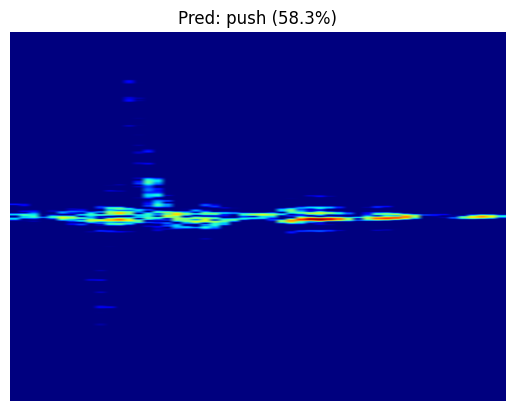

In [ ]:
# Test with Single Image
TEST_DATA_DIR = "./test_data"
image_name = "k_left_1.png"
test_image_path = f"{TEST_DATA_DIR}/{image_name}" # Replace with a real path

# We need the validation transforms here
from torchvision import transforms
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

if os.path.exists(test_image_path):
    pred_class, conf, all_probs = predict_single_image(model, test_image_path, val_transforms)

    print("-" * 30)
    print(f"Image: {test_image_path}")
    print(f"Prediction: {pred_class.upper()}")
    print(f"Confidence: {conf:.2f}%")
    print("-" * 30)

    # Optional: Print all probabilities
    print("Class Probabilities:")
    for i, cls in enumerate(CLASSES):
        print(f"  {cls}: {all_probs[i]*100:.2f}%")

    # Optional: Display the image with prediction title
    plt.imshow(Image.open(test_image_path))
    plt.title(f"Pred: {pred_class} ({conf:.1f}%)")
    plt.axis('off')
    plt.show()
else:
    print(f"Test image not found: {test_image_path}")

#### Misc

In [ ]:
# Evaluate the model on the training set
evaluate_test_set(model, train_loader)